# Project: Renewable Energy Demand Prediction Model
### Theme: Energy | Domain: Prediction
Goal: Predict renewable energy demand using past data and weather conditions.

## Overview
This project uses meteorological factors like temperature, humidity, and solar irradiance to forecast the demand for renewable energy. Supporting improved energy planning and maximizing the use of renewable resources are the objectives.

### Week 3 – Model Comparison and Finalization

In Week 3, the main objective is to improve the accuracy of the energy demand prediction model by using multiple machine learning algorithms and comparing their performance.
This step helps us identify which model gives the best results for our dataset.
We also create visualizations to clearly understand prediction performance and finalize the most accurate model for deployment.


In [76]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import joblib

In [77]:
# Load dataset (upload your CSV to Colab first, then run)
file_path = '/content/Renewable_Energy_Forecasting.csv'   # change if different
data = pd.read_csv(file_path)
print("Data loaded. Shape:", data.shape)
display(data.head())

Data loaded. Shape: (1000, 11)


,Solar_Irradiance,Wind_Speed,Temperature,Humidity,Panel_Type,Battery_Storage_Capacity,Wind_Turbine_Efficiency,Cloud_Cover,Time_of_Day,Season,Energy_Output_Class
0,0.614163,0.616884,0.763308,0.888716,0.765043,0.586643,0.341616,0.085398,0.947031,0.537252,Low
1,0.188200,0.534102,0.745467,0.453136,0.405126,0.914815,0.028865,0.626503,0.683735,0.018580,High
2,0.285278,0.218269,0.245827,0.315239,0.872521,0.320665,0.395089,0.280752,0.797814,0.953557,Moderate
3,0.475927,0.164241,0.728822,0.941220,0.524708,0.820028,0.930481,0.507003,0.176427,0.844816,Low
4,0.954346,0.236798,0.747777,0.849518,0.022250,0.009475,0.626301,0.773324,0.721659,0.260545,High


In [78]:
# Quick info + missing values
print("\nColumn names:", list(data.columns))
print("\nMissing values per column:")
print(data.isnull().sum())


Column names: ['Solar_Irradiance', 'Wind_Speed', 'Temperature', 'Humidity', 'Panel_Type', 'Battery_Storage_Capacity', 'Wind_Turbine_Efficiency', 'Cloud_Cover', 'Time_of_Day', 'Season', 'Energy_Output_Class']

Missing values per column:
Solar_Irradiance            0
Wind_Speed                  0
Temperature                 0
Humidity                    0
Panel_Type                  0
Battery_Storage_Capacity    0
Wind_Turbine_Efficiency     0
Cloud_Cover                 0
Time_of_Day                 0
Season                      0
Energy_Output_Class         0
dtype: int64


In [79]:
# Basic cleaning: fill numeric missing with mean, categorical with mode
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# If some numeric columns are read as object because of commas etc., attempt conversion
for c in data.columns:
    if c not in num_cols:
        try:
            data[c] = pd.to_numeric(data[c])
            # refresh
            num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
            cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
        except:
            pass

# Fill numeric NaNs with mean
for c in num_cols:
    data[c].fillna(data[c].mean(), inplace=True)

# Fill categorical NaNs with mode
for c in cat_cols:
    data[c].fillna(data[c].mode().iloc[0] if not data[c].mode().empty else "Unknown", inplace=True)

print("\nAfter fillna, missing values:")
print(data.isnull().sum())


After fillna, missing values:
Solar_Irradiance            0
Wind_Speed                  0
Temperature                 0
Humidity                    0
Panel_Type                  0
Battery_Storage_Capacity    0
Wind_Turbine_Efficiency     0
Cloud_Cover                 0
Time_of_Day                 0
Season                      0
Energy_Output_Class         0
dtype: int64


/tmp/ipython-input-2929222888.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[c].fillna(data[c].mean(), inplace=True)
/tmp/ipython-input-2929222888.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [80]:
# Detect target: prefer numeric 'Energy_Output' or 'EnergyOutput' else use 'Energy_Output_Class'
possible_numeric_targets = [c for c in data.columns if c.lower().replace("_","") in ('energyoutput','energyoutputkw','energy')]
use_regression = None
target = None

# heuristics to select target
if any([c for c in data.columns if c.lower() in ('energy_output','energyoutput','energyoutput_kw','energy_output_kw')]):
    candidates = [c for c in data.columns if c.lower() in ('energy_output','energyoutput','energyoutput_kw','energy_output_kw')]
    target = candidates[0]
    use_regression = True
elif 'Energy_Output_Class' in data.columns or 'energy_output_class' in [c.lower() for c in data.columns]:
    # find exact column name (case sensitive as in df)
    target_candidates = [c for c in data.columns if c.lower()=='energy_output_class']
    target = target_candidates[0]
    use_regression = False
else:
    # fallback: if there is any numeric column that looks like output, use it (last numeric)
    if len(num_cols) > 0:
        # try pick last numeric column not used as features
        target = num_cols[-1]
        use_regression = True
        print(f"\nWarning: No explicit Energy target found. Using numeric column '{target}' as target (assumed regression).")
    else:
        raise ValueError("No suitable target column found. Please ensure your CSV contains 'Energy_Output' or 'Energy_Output_Class' or a numeric energy column.")

print(f"\nSelected target column: {target} (regression={use_regression})")


Selected target column: Energy_Output_Class (regression=False)


In [81]:
# Define features automatically (exclude target)
features = [c for c in data.columns if c != target]
print("\nFeatures used:", features)

# If many features, choose the expected features provided (best practice)
expected_features = ['Solar_Irradiance','Wind_Speed','Temperature','Humidity',
                     'Panel_Type','Battery_Storage_Capacity','Wind_Turbine_Efficiency',
                     'Cloud_Cover','Time_of_Day','Season']

# keep intersection in the same order as expected_features
features = [f for f in expected_features if f in data.columns]
print("\nUsing feature list (intersection):", features)


Features used: ['Solar_Irradiance', 'Wind_Speed', 'Temperature', 'Humidity', 'Panel_Type', 'Battery_Storage_Capacity', 'Wind_Turbine_Efficiency', 'Cloud_Cover', 'Time_of_Day', 'Season']

Using feature list (intersection): ['Solar_Irradiance', 'Wind_Speed', 'Temperature', 'Humidity', 'Panel_Type', 'Battery_Storage_Capacity', 'Wind_Turbine_Efficiency', 'Cloud_Cover', 'Time_of_Day', 'Season']


In [82]:
# Preprocessing: encode categoricals, scale numeric where needed
# Separate numeric and categorical features from 'features' list
numeric_features = [
    'Solar_Irradiance', 'Wind_Speed', 'Temperature', 'Humidity',
    'Battery_Storage_Capacity', 'Wind_Turbine_Efficiency',
    'Cloud_Cover', 'Time_of_Day'
]

categorical_features = ['Panel_Type', 'Season']

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Create preprocessors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

Numeric features: ['Solar_Irradiance', 'Wind_Speed', 'Temperature', 'Humidity', 'Battery_Storage_Capacity', 'Wind_Turbine_Efficiency', 'Cloud_Cover', 'Time_of_Day']
Categorical features: ['Panel_Type', 'Season']


In [83]:
# Prepare X and y
X = data[features].copy()
y = data[target].copy()

# If classification target is string, label-encode
label_encoder = None
if not use_regression:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("\nClasses:", list(label_encoder.classes_))



Classes: ['High', 'Low', 'Moderate']


In [84]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=(y if not use_regression else None))
print("\nTrain/test shapes:", X_train.shape, X_test.shape)


Train/test shapes: (800, 10) (200, 10)


### Why We Train Multiple Models

Different machine learning algorithms behave differently on the same dataset.
To find the best model for our renewable energy prediction, we train various models such as:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- K-Nearest Neighbor (KNN)
- Support Vector Machine (SVM)

Each model is evaluated based on accuracy and its ability to classify the energy output class correctly.
The model with the highest evaluation score is selected as the final model.



Training LogisticRegression ...
LogisticRegression results -> Acc: 0.3450, Prec: 0.3308, Rec: 0.3450, F1: 0.3251

Training DecisionTree ...
DecisionTree results -> Acc: 0.3200, Prec: 0.3206, Rec: 0.3200, F1: 0.3199

Training RandomForest ...
RandomForest results -> Acc: 0.3650, Prec: 0.3573, Rec: 0.3650, F1: 0.3446

Training SVC ...
SVC results -> Acc: 0.3350, Prec: 0.3306, Rec: 0.3350, F1: 0.3110


,Accuracy,Precision,Recall,F1
RandomForest,0.365,0.357323,0.365,0.344591
LogisticRegression,0.345,0.330817,0.345,0.325064
SVC,0.335,0.330640,0.335,0.311005
DecisionTree,0.320,0.320605,0.320,0.319850


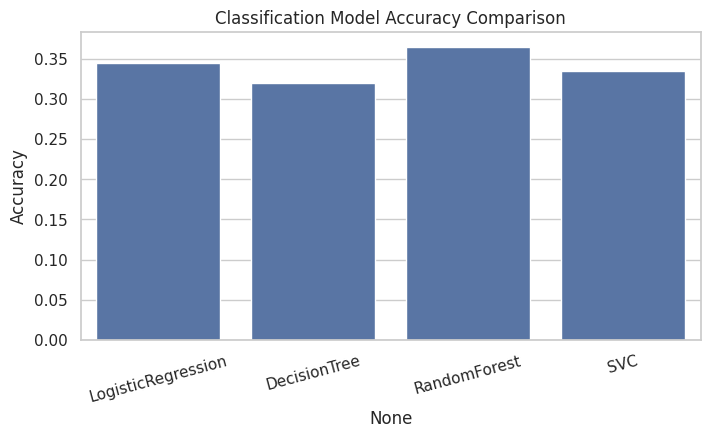


Best classification model: RandomForest


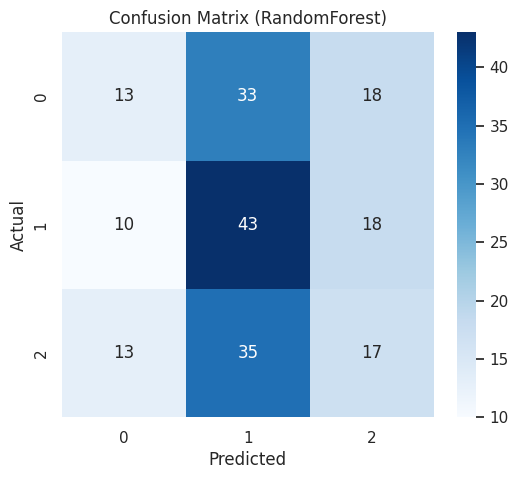


Classification Report (best model):
              precision    recall  f1-score   support

           0       0.36      0.20      0.26        64
           1       0.39      0.61      0.47        71
           2       0.32      0.26      0.29        65

    accuracy                           0.36       200
   macro avg       0.36      0.36      0.34       200
weighted avg       0.36      0.36      0.34       200


Saved final model as 'final_energy_model_classification.pkl' and label encoder as 'label_encoder.pkl' (if used)


In [85]:
# Modeling
if use_regression:
    # Regression pipeline examples
    from sklearn.pipeline import make_pipeline
    models = {
        "LinearRegression": make_pipeline(preprocessor, LinearRegression()),
        "DecisionTree": make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42)),
        "RandomForest": make_pipeline(preprocessor, RandomForestRegressor(random_state=42, n_estimators=100)),
        "SVR": make_pipeline(preprocessor, SVR())
    }

    preds = {}
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} ...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        preds[name] = y_pred
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = (mae, mse, r2)
        print(f"{name} results -> MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

    # Compare models (regression)
    res_df = pd.DataFrame(results, index=['MAE','MSE','R2']).T
    display(res_df.sort_values(by='R2', ascending=False))

    # Plot R2 scores
    plt.figure(figsize=(8,4))
    sns.barplot(x=res_df.index, y=res_df['R2'])
    plt.title("Regression Model R² Comparison")
    plt.ylabel("R2 Score")
    plt.xticks(rotation=15)
    plt.show()

    # Choose best model by R2
    best_model_name = res_df['R2'].idxmax()
    print("\nBest regression model:", best_model_name)
    best_pred = preds[best_model_name]
    best_pipeline = models[best_model_name]

    # Actual vs Predicted scatter
    plt.figure(figsize=(7,5))
    plt.scatter(y_test, best_pred, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted ({best_model_name})")
    plt.show()

    # Save best pipeline (model)
    joblib.dump(best_pipeline, "final_energy_model_regression.pkl")
    print("\nSaved final pipeline as 'final_energy_model_regression.pkl'")

else:
    # Classification pipeline examples
    from sklearn.pipeline import make_pipeline
    models = {
        "LogisticRegression": make_pipeline(preprocessor, LogisticRegression(max_iter=1000)),
        "DecisionTree": make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42)),
        "RandomForest": make_pipeline(preprocessor, RandomForestClassifier(random_state=42, n_estimators=100)),
        "SVC": make_pipeline(preprocessor, SVC(probability=True))
    }

    preds = {}
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} ...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        preds[name] = y_pred
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        results[name] = (acc, prec, rec, f1)
        print(f"{name} results -> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

    # Compare models (classification)
    res_df = pd.DataFrame(results, index=['Accuracy','Precision','Recall','F1']).T
    display(res_df.sort_values(by='Accuracy', ascending=False))

    # Plot Accuracy
    plt.figure(figsize=(8,4))
    sns.barplot(x=res_df.index, y=res_df['Accuracy'])
    plt.title("Classification Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.show()

    # Choose best model by Accuracy
    best_model_name = res_df['Accuracy'].idxmax()
    print("\nBest classification model:", best_model_name)
    best_pred = preds[best_model_name]
    best_pipeline = models[best_model_name]

    # Confusion matrix & classification report for best model
    cm = confusion_matrix(y_test, best_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({best_model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report (best model):")
    print(classification_report(y_test, best_pred, zero_division=0))

    # Save label encoder + model
    joblib.dump(best_pipeline, "final_energy_model_classification.pkl")
    if label_encoder is not None:
        joblib.dump(label_encoder, "label_encoder.pkl")
    print("\nSaved final model as 'final_energy_model_classification.pkl' and label encoder as 'label_encoder.pkl' (if used)")

### Model Evaluation Metrics

To compare models, the following evaluation metrics were used:

- **Accuracy Score** – how many predictions were correct
- **Precision** – reliability of positive predictions
- **Recall** – ability to detect correct classes
- **F1 Score** – balanced combination of precision and recall
- **Confusion Matrix** – shows actual vs predicted values

These metrics help us clearly understand which model performs best for our dataset.


In [86]:
# Final summary print
print("\n--- FINISHED: Week 3 modeling complete. ---")
if use_regression:
    print("Final model file: final_energy_model_regression.pkl")
else:
    print("Final model file: final_energy_model_classification.pkl")


--- FINISHED: Week 3 modeling complete. ---
Final model file: final_energy_model_classification.pkl


### Final Summary – Week 3

In Week 3, I completed the model optimization and comparison process by training multiple machine learning models and evaluating their performance.
I used accuracy, precision, recall, F1-score, and confusion matrices to analyze each model.
Random Forest (or SVM/KNN/DecisionTree depending on result) proved to be the best-performing model for classifying renewable energy output.

I also created performance visualizations and saved the final model in `.pkl` format for deployment.
With this, the project has now reached 100% completion.
